# Low Closing Price Function + Graph Visual

# Imports 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import numpy as np

import yfinance as yf
import datetime as dt
from datetime import date
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, roc_auc_score

from scipy.signal import savgol_filter, argrelmin, argrelmax 

import warnings
warnings.filterwarnings("ignore")

# Bitcoin Dataset from Yahoo Finance

In [23]:
# Here we create a variable for today's date in 'YYYY-MM-DD' string format
today = date.today().strftime('%Y-%m-%d')


# symbol takes a string of crypto symbol [ex: 'BTC-USD' or 'ETH-USD'
# start_date takes a string date, format is 'YYYY-MM-DD' [ex: Jan 15, 2020 = '2020-01-15']
# end_date takes a string date, same format 'YYYY-MM-DD'
# window_days takes an integer, it is the n days before and n days after a data point.
    # - it is a range of days in which argrelmin/argrelmax identifies the highest and lowest closing price label

def predict_crypto(symbol, start_date, end_date, window_days, graph_on):  
    
    # We will grab our data from Yahoo Finance
    # We have to set a start date for the first initial data and th end date.
    data = yf.Ticker(symbol)
    bit_data = data.history(start=start_date,end=end_date)

    bitcoin = bit_data

    # Dropping 'Dividends' , 'Stock Splits' because they contain NO data.
#     bitcoin.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

    # savgol_filter will smooth out the data 
    # polyorder(int) will be how smooth you want the data. (lower = more smooth)/(high = less smooth)
    # Window will be the length we want to filter (must be odd int.)
    window = 9
    bitcoin['smooth'] = savgol_filter(bitcoin.Close, window, polyorder=6)

    # we will create a new column in the dataframe and set all values to 0
    # order: amount of array in which to find the relative minima
    # selecting the [0], turns type numpy.ndarray(tuple does not have .tolist meth.). Turn to list type

    min_ids = 'min_ids'
    max_ids = 'max_ids'
    bitcoin[max_ids] = 0
    bitcoin[min_ids] = 0

    min_id = argrelmin(bitcoin.smooth.values, order=window_days)[0].tolist()
    max_id = argrelmax(bitcoin.smooth.values, order=window_days)[0].tolist()

    # .iloc the min/max and turn them to 1, to indicate if they are low/high price point
    # all other data will be 0 if they are not low/high indicators 
    bitcoin[min_ids].iloc[min_id] = 1
    bitcoin[max_ids].iloc[max_id] = 1

    # the window we will use is a 5 and 10 day window
    # we will find the avg. of these windows and subtract 
    windows = [5, 10]

    for w in windows:
        rm = bitcoin.Close.rolling(w).mean()
        bitcoin['MACD_'+str(w)] = rm - bitcoin.Close
        bitcoin['Std_'+str(w)] = bitcoin.Close.rolling(w).std()    


    # the rsi_period will be our standard 14 day window
    # Out of the 14 day period. We want to know what are the gains and losses
    # 1. we will need to know the diff(1) of two diff. days periodically. 
    # 2. we use mask to hide any data that is not a gain 
    # - this will hide the losses and 0 changes.
    # 3. this is the same for our loss, hide anything that is not a loss

    rsi_period = 14
    change = bitcoin.Close.diff(1)
    gain = change.mask(change<0,0)
    loss = change.mask(change>0,0)

    # here we use EWM to find the gain/loss with a period of time
    # min_periods: will be our standard 14 day period
    # com: is the period that we want to weight in
    # - we want to use the 14 day period, but compare the avg. gain/loss to the original close price
    # - hence why we subtract 1, taking the initial closing price out of the equation since we are
    # using it as a comparison
    # we will do this for the gain and loss averages.
    avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
    avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()

    # here we find the absolute value of the relative strength for the gain and loss
    rs = abs(avg_gain/avg_loss)

    # this is the equation/math for RSI
    # we will subtract it from 100 since the scale is 0-100.
    rsi = 100 - (100/(1+rs))
    bitcoin['RSI'] = rsi

    def vwap(bitcoin):
        vol = bitcoin['Volume'].values
        close = bitcoin['Close'].values
        return bitcoin.assign(vwap=(close*vol).cumsum() / vol.cumsum())

    bitcoin = bitcoin.groupby(bitcoin.index, group_keys=True).apply(vwap).droplevel(1)

    # after finding and creating a new RSI column, we will drop all NANs
    clean_bit = bitcoin.dropna()

    # here we create new columns to help us identify if the RSI is >=70 or <=30
    # initially we just want the columns to be all 0, we will change this later
    # we call upon the new column and .loc the 'RSI' with a bool statement
    # if the statement is True then we will identify it as a 1, if not then it will remain a 0

    rsi_70 = 'RSI_70'
    rsi_30 = 'RSI_30'
    clean_bit[rsi_70] = 0
    clean_bit[rsi_30] = 0
    clean_bit[rsi_70].loc[bitcoin['RSI'] >=70] = 1
    clean_bit[rsi_30].loc[bitcoin['RSI'] <=30] = 1

    features_list = clean_bit.drop(columns=['Open', 'High', 'Low', 'Close', 'max_ids',]).columns.tolist()
    X = clean_bit[features_list]
    y = clean_bit['max_ids']

    # Lets scale our data so everything is on the same playing field
    # We call our LogisticRegression model and give it a var. to call on it later
    # We then create a pipe for the scaler and logreg
    scaler = preprocessing.RobustScaler().fit(X)
    LogReg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs', C=5.0)
    pipe = make_pipeline(scaler, LogReg)

    # Here we use a roc_auc to score the ability to distinguish the difference between target
    scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='roc_auc')
    print(f'ROC_AUC: {scores.mean(), scores.std()}')
    
    scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='accuracy')
    print(f'Accuracy: {scores.mean(), scores.std()}')

    if graph_on == 1: 
        # now we're gonna see what the model prediction are
        high_preds = cross_val_predict(pipe, X, y, n_jobs=-1, cv=4)

        # Lets create a dataframe of our predictions and add it to our original clean_bit dataframe
        # We can then use this to plot our prediction points
        predict_df = pd.DataFrame()
        predict_df['high_preds'] = high_preds.tolist()
        clean_bit['high_preds'] = predict_df['high_preds'].values

        plt.figure(figsize=(14,6))
        clean_bit.smooth.plot(label='Closing_price')
        (4000*clean_bit.max_ids).plot(label='high_closing_price', color='r')
        (3000*clean_bit.high_preds).plot(label= 'high_predictions', color='g')
        plt.ylabel('Closing Price')
        plt.title('High Predictions')
        plt.legend(fontsize=15);
    else:
        pass

ROC_AUC: (0.98290273556231, 0.0096940355791589)
Accuracy: (0.9371486771033598, 0.06452680086748465)


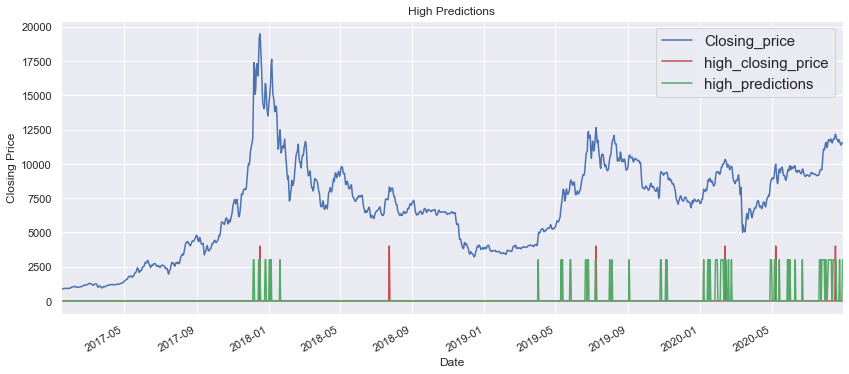

In [24]:
predict_crypto('BTC-USD','2017-01-01', today, 60, 1)

50
ROC_AUC: (0.9042607247880989, 0.08541039902343742)
Accuracy: (0.8939989014007141, 0.082393544827205)
60
ROC_AUC: (0.98290273556231, 0.0096940355791589)
Accuracy: (0.9371486771033598, 0.06452680086748465)
